# SSL Contrastive Learning using SimCLR2 Notebook
Installing Required libraries
Step 1.1- Please refer to the "Technical Requirements" section in the book for the neccessary packages to be installed. Please note that chapter has differnt Pytorch Lightning version and thus diff torch dependancies. Some functions may not work with other versions than what is tested below, so please ensure correct versions.

In [ ]:
pip install pytorch-lightning==1.5.2

     |████████████████████████████████| 1.0 MB 14.3 MB/s 
     |████████████████████████████████| 596 kB 83.4 MB/s 
     |████████████████████████████████| 829 kB 65.5 MB/s 
     |████████████████████████████████| 136 kB 64.7 MB/s 
     |████████████████████████████████| 398 kB 74.8 MB/s 
     |████████████████████████████████| 1.1 MB 52.0 MB/s 
     |████████████████████████████████| 94 kB 1.5 MB/s 
     |████████████████████████████████| 271 kB 74.1 MB/s 
     |████████████████████████████████| 144 kB 73.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=306e9db3818eed5904a2235b8450aebd0bc21c971b03f6688d5a0413b348e62c
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exist

In [ ]:
import os
import urllib.request
from copy import deepcopy
from urllib.error import HTTPError
from sklearn import preprocessing

import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as DataLoader

from IPython.display import set_matplotlib_formats
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import Callback

import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision import datasets
from torchvision.datasets import STL10
from tqdm.notebook import tqdm


from torch.optim import Adam

import numpy as np
from torch.optim.lr_scheduler import OneCycleLR

import zipfile
from PIL import Image
import cv2

In [ ]:
print(torchvision.__version__)

0.11.1+cu111


In [ ]:
print(torch.__version__, torchvision.__version__, pl.__version__)

1.10.0+cu111 0.11.1+cu111 1.5.2


In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
NUM_WORKERS = os.cpu_count()
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cuda:0
Number of workers: 8


In [ ]:
pl.seed_everything(96)

Global seed set to 96


96

In [ ]:
class DataAugTransform:
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]
augmentation_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        #transforms.GaussianBlur(kernel_size=9),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "bookdata/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "booksaved_models/")

In [ ]:
unlabeled_data = STL10(
    root=DATASET_PATH,
    split="unlabeled",
    download=True,
    transform=DataAugTransform(augmentation_transforms, n_views=2),
)
train_data_contrast = STL10(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=DataAugTransform(augmentation_transforms, n_views=2),
)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting bookdata/stl10_binary.tar.gz to bookdata/
Files already downloaded and verified


Global seed set to 96


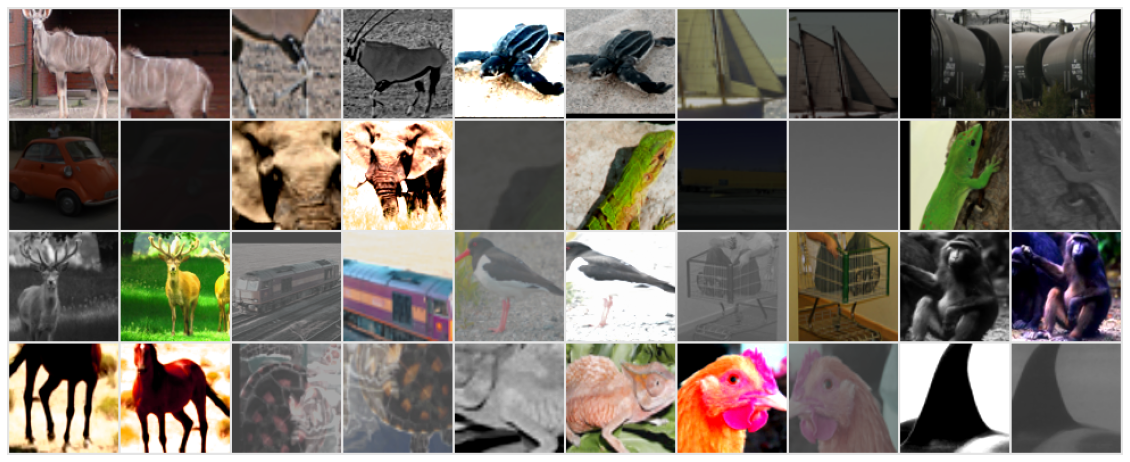

In [ ]:
# Visualize some examples
pl.seed_everything(96)
NUM_IMAGES = 20
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=10, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(20, 10))
#plt.title("Augmented image examples of the STL10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
#plt.close()

In [ ]:
class NTXentLoss(torch.nn.Module):

    def __init__(self, device, batch_size, temperature, use_cosine_similarity):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.softmax = torch.nn.Softmax(dim=-1)
        self.mask_samples_from_same_repr = self._get_correlated_mask().type(torch.bool)
        self.similarity_function = self._get_similarity_function(use_cosine_similarity)
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum").cuda()

    def _get_similarity_function(self, use_cosine_similarity):
        if use_cosine_similarity:
            self._cosine_similarity = torch.nn.CosineSimilarity(dim=-1)
            return self._cosine_simililarity
        else:
            return self._dot_simililarity

    def _get_correlated_mask(self):
        diag = np.eye(2 * self.batch_size)
        l1 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=-self.batch_size)
        l2 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=self.batch_size)
        mask = torch.from_numpy((diag + l1 + l2))
        mask = (1 - mask).type(torch.bool)
        return mask.to(self.device)

    @staticmethod
    def _dot_simililarity(x, y):
        v = torch.tensordot(x.unsqueeze(1), y.T.unsqueeze(0), dims=2)
        return v

    def _cosine_simililarity(self, x, y):
        v = self._cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def forward(self, zis, zjs):
        representations = torch.cat([zjs, zis], dim=0)

        similarity_matrix = self.similarity_function(representations, representations)
        # filter out the scores from the positive samples
        l_pos = torch.diag(similarity_matrix, self.batch_size)
        r_pos = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([l_pos, r_pos]).view(2 * self.batch_size, 1)

        negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)

        logits = torch.cat((positives, negatives), dim=1)
        logits /= self.temperature

        labels = torch.zeros(2 * self.batch_size).to(self.device).long()
        loss = self.criterion(logits, labels)

        return loss / (2 * self.batch_size)

In [ ]:
class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim, freeze=True):
        super(ResNetSimCLR, self).__init__()
        
        # Number of input features into the last linear layer
        num_ftrs = base_model.fc.in_features
        # Remove last layer of resnet
        self.features = nn.Sequential(*list(base_model.children())[:-1])
        if freeze:
            self._freeze()

        # header projection MLP - for SimCLR 
        self.l1 = nn.Linear(num_ftrs, 2*num_ftrs)
        self.l2_bn = nn.BatchNorm1d(2*num_ftrs)
        self.l2 = nn.Linear(2*num_ftrs, num_ftrs)
        self.l3_bn = nn.BatchNorm1d(num_ftrs)
        self.l3 = nn.Linear(num_ftrs, out_dim)

    def _freeze(self):
        num_layers = len(list(self.features.children())) # 9 layers, freeze all but last 2
        current_layer = 1
        for child in list(self.features.children()):
            if current_layer > num_layers-2:
                for param in child.parameters():
                    param.requires_grad = True
            else:
                for param in child.parameters():
                    param.requires_grad = False
            current_layer += 1

    def forward(self, x):
        h = self.features(x)
        h = h.squeeze()

        if len(h.shape) == 1:
            h = h.unsqueeze(0)

        x_l1 = self.l1(h)
        x = self.l2_bn(x_l1)
        x = F.selu(x)
        x = self.l2(x)
        x = self.l3_bn(x)
        x = F.selu(x)
        x = self.l3(x)
        return h, x_l1, x

In [ ]:
import yaml # Handles config file loading
# Load config file
config = '''
batch_size: 128
epochs: 100
weight_decay: 10e-6
out_dim: 256

dataset:
  s: 1
  input_shape: (96,96,3)
  num_workers: 4

optimizer:
  lr: 0.0001

loss:
  temperature: 0.05
  use_cosine_similarity: True

lr_schedule:
  max_lr: .1
  total_steps: 1500

model:
  out_dim: 128
  base_model: "resnet50"
'''
config = yaml.full_load(config)

In [ ]:
class simCLR(pl.LightningModule):

    def __init__(self, model, config, optimizer=Adam, loss=NTXentLoss):
        super(simCLR, self).__init__()
        # Config file (dictionary) to pass on parameters to each module: optimizer, loss, lr_schedule, 
        self.config = config

        # Optimizer
        self.optimizer = optimizer

        # Model
        self.model = model
        
        # Loss
        self.loss = loss('cuda', self.config['batch_size'], **self.config['loss'])

    # Prediction/inference
    def forward(self, x):
        return self.model(x)

    # Sets up optimizer
    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), **self.config['optimizer'])
        scheduler = OneCycleLR(optimizer, **self.config["lr_schedule"])
        return [optimizer], [scheduler]

    # Training loops
    def training_step(self, batch, batch_idx):
        x, y = batch
        xis, xjs = x
        ris, _, zis = self(xis)
        rjs, _, zjs = self(xjs)

        zis = F.normalize(zis, dim=1)
        zjs = F.normalize(zjs, dim=1)

        loss = self.loss(zis, zjs)
        return loss

    # Validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        xis, xjs = x
        ris, _, zis = self(xis)
        rjs, _, zjs = self(xjs)

        zis = F.normalize(zis, dim=1)
        zjs = F.normalize(zjs, dim=1)

        loss = self.loss(zis, zjs)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        loss = None
        return loss

def _get_model_checkpoint():
    return ModelCheckpoint(
        filepath=os.path.join(os.getcwd(),"checkpoints","best_val_models"),
        save_top_k = 3,
        monitor="val_loss"
    )

In [ ]:
train_loader = DataLoader.DataLoader(
            unlabeled_data,
            batch_size=128,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
val_loader = DataLoader.DataLoader(
            train_data_contrast,
            batch_size=128,
            shuffle=False,
            drop_last=True,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )

In [ ]:
resnet = models.resnet50(pretrained=True)

simclr_resnet = ResNetSimCLR(base_model=resnet, out_dim=config['out_dim'])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# Creates the simCLR model with the specified architecture from aboce
model = simCLR(config=config, model=simclr_resnet)

In [ ]:
# Initializes the model trainer
trainer = pl.Trainer(gpus=-1,max_epochs=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
# Fits the model
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | ResNetSimCLR | 40.8 M
1 | loss  | NTXentLoss   | 0     
---------------------------------------
32.3 M    Trainable params
8.5 M     Non-trainable params
40.8 M    Total params
163.313   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 96


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# saving the model 
torch.save(model.state_dict(), 'weights_only.pth')
torch.save(model, 'entire_model.pth')

In [ ]:
def get_stl10_data_loaders(download, shuffle=False, batch_size=128):
  train_dataset = datasets.STL10('./data', split='train',
  download=download,
  transform=transforms.
  ToTensor())
  train_loader = DataLoader.DataLoader(train_dataset, batch_size=batch_size,num_workers=4, drop_last=False,
  shuffle=shuffle)
  test_dataset = datasets.STL10('./data', split='test',
  download=download,
  transform=transforms.
  ToTensor())
  test_loader = DataLoader.DataLoader(test_dataset, batch_size=batch_size,
  num_workers=4, drop_last=False,
  shuffle=shuffle)
  return train_loader, test_loader

In [ ]:
def _load_resnet_model(checkpoints_folder):
  model = torch.load('entire_model.pth')
  model.eval()

  state_dict = torch.load(os.path.join(checkpoints_folder, 'weights_only.pth'), map_location=torch.device(device))
  model.load_state_dict(state_dict)
  model = model.to(device)
  return model

In [ ]:
class ResNetFeatureExtractor(object):
  def __init__(self, checkpoints_folder):
    self.checkpoints_folder = checkpoints_folder
    self.model = _load_resnet_model(checkpoints_folder)

  def _inference(self, loader):
    feature_vector = []
    labels_vector = []
    for batch_x, batch_y in loader:
      batch_x = batch_x.to(device)
      labels_vector.extend(batch_y)
      features, _, z = self.model(batch_x)
      feature_vector.extend(features.cpu().detach().numpy())
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    return feature_vector, labels_vector

  def get_resnet_features(self):
    train_loader, test_loader = get_stl10_data_loaders(download=True)
    X_train_feature, y_train = self._inference(train_loader)
    X_test_feature, y_test = self._inference(test_loader)
    return X_train_feature, y_train, X_test_feature, y_test

In [ ]:
checkpoints_folder = ''
resnet_feature_extractor = ResNetFeatureExtractor(checkpoints_folder)
X_train_feature, y_train, X_test_feature, y_test = resnet_feature_extractor.get_resnet_features()

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Features shape (5000, 2048)
Features shape (8000, 2048)


In [ ]:
import torch.nn as nn

class LogisticRegression(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super(LogisticRegression, self).__init__()
        self.model = nn.Linear(n_features, n_classes)

    def forward(self, x):
        return self.model(x)

In [ ]:
class LogiticRegressionEvaluator(object):
  def __init__(self, n_features, n_classes):
    self.log_regression = LogisticRegression(n_features, n_classes).to(device)
    self.scaler = preprocessing.StandardScaler()

  def _normalize_dataset(self, X_train, X_test):
    print("Standard Scaling Normalizer")
    self.scaler.fit(X_train)
    X_train = self.scaler.transform(X_train)
    X_test = self.scaler.transform(X_test)
    return X_train, X_test

  @staticmethod
  def _sample_weight_decay():
    # We selected the l2 regularization parameter from a range of 45 logarithmically spaced values between 10−6 and 105
    weight_decay = np.logspace(-6, 5, num=45, base=10.0)
    weight_decay = np.random.choice(weight_decay)
    print("Sampled weight decay:", weight_decay)
    return weight_decay

  def eval(self, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
      self.log_regression.eval()
      for batch_x, batch_y in test_loader:
          batch_x, batch_y = batch_x.to(device), batch_y.to(device)
          logits = self.log_regression(batch_x)

          predicted = torch.argmax(logits, dim=1)
          total += batch_y.size(0)
          correct += (predicted == batch_y).sum().item()

      final_acc = 100 * correct / total
      self.log_regression.train()
      return final_acc


  def create_data_loaders_from_arrays(self, X_train, y_train, X_test, y_test):
    X_train, X_test = self._normalize_dataset(X_train, X_test)

    train = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).type(torch.long))
    train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=False)

    test = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).type(torch.long))
    test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)
    return train_loader, test_loader

  def train(self, X_train, y_train, X_test, y_test):
    
    train_loader, test_loader = self.create_data_loaders_from_arrays(X_train, y_train, X_test, y_test)

    weight_decay = self._sample_weight_decay()

    optimizer = torch.optim.Adam(self.log_regression.parameters(), 3e-4, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    best_accuracy = 0

    for e in range(200):
      
      for batch_x, batch_y in train_loader:

        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()

        logits = self.log_regression(batch_x)

        loss = criterion(logits, batch_y)

        loss.backward()
        optimizer.step()

      epoch_acc = self.eval(test_loader)
      
      if epoch_acc > best_accuracy:
        #print("Saving new model with accuracy {}".format(epoch_acc))
        best_accuracy = epoch_acc
        torch.save(self.log_regression.state_dict(), 'log_regression.pth')

    print("--------------")
    print("Done training")
    print("Best accuracy:", best_accuracy)

In [ ]:
log_regressor_evaluator = LogiticRegressionEvaluator(n_features=X_train_feature.shape[1], n_classes=10)

log_regressor_evaluator.train(X_train_feature, y_train, X_test_feature, y_test)

Standard Scaling Normalizer
Sampled weight decay: 0.1
--------------
Done training
Best accuracy: 86.15
